# `Project Serenity`
A project to compare a gradient descent ensemble boosted tree (regressor!) to `Forecaster`.

In [62]:
from serenity import read_data, pipelines, permutations, compare_predict_vs_test
from xgboost import plot_tree, plot_importance
import matplotlib.pyplot as plt
from random import randrange
import numpy as np
import pandas as pd
%config InlineBackend.figure_format ='retina'
import sys, os

class suppress_print():
    def __enter__(self):
        self.original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self.original_stdout

# Model: `XGBRegressor()`
- Test-Train splits have a test size of `0.2`.
- Data leakage accounted for with piplines handling preprocessing before cross-validation.
- Capable of handling categorical or numerical columns.
- Categorical uses `OneHotEncoder()` and the most frequent string if there are missing values using `SimpleImputer()`.
- Numerical preprocessing steps use the `RobustScalar()` method and a mean strategy using `SimpleImputer()`.
- Need to investigate why `count:possion` gives the best accuracy.

In [63]:
hyper_parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
                        'objective':['count:poisson'],#['reg:squarederror'],['count:poisson']['reg:squaredlogerror']
                        'learning_rate': [0.05], #so called `eta` value
                        'max_depth': [5,6,7],
                        'min_child_weight': [0,],
                        'subsample': [0.2],
                        'colsample_bytree': [1],
                        'n_estimators': [500,]}


features = ['pl_radj', 'glat', 'glon', 'elat', 'elon', 'sy_dist', 'disc_year', 'st_age', 'st_teff', 'pl_orblper', 'pl_tranmid', 'pl_orbper', 'pl_name',]
#features = ['pl_radj', 'pl_name']
objective = 'pl_massj'
override = False
random_seed = randrange(100)
X_train, X_test, y_train, y_test, X, y = read_data('data/ML_nasa_tess_viable.csv.xz', objective, features, seed=random_seed, override_features=override)
#X_train, X_test, y_train, y_test, X, y = read_data('data/nasa_full.csv.xz', objective, features, seed=3)
#X_train, X_test, y_train, y_test, X, y = read_data('data/kep.csv.gz', objective, features, override_features=override)

clf, y_pred = pipelines(hyper_parameters, seed=random_seed)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
MAE: 0.5824
Accuracy: 64.87%


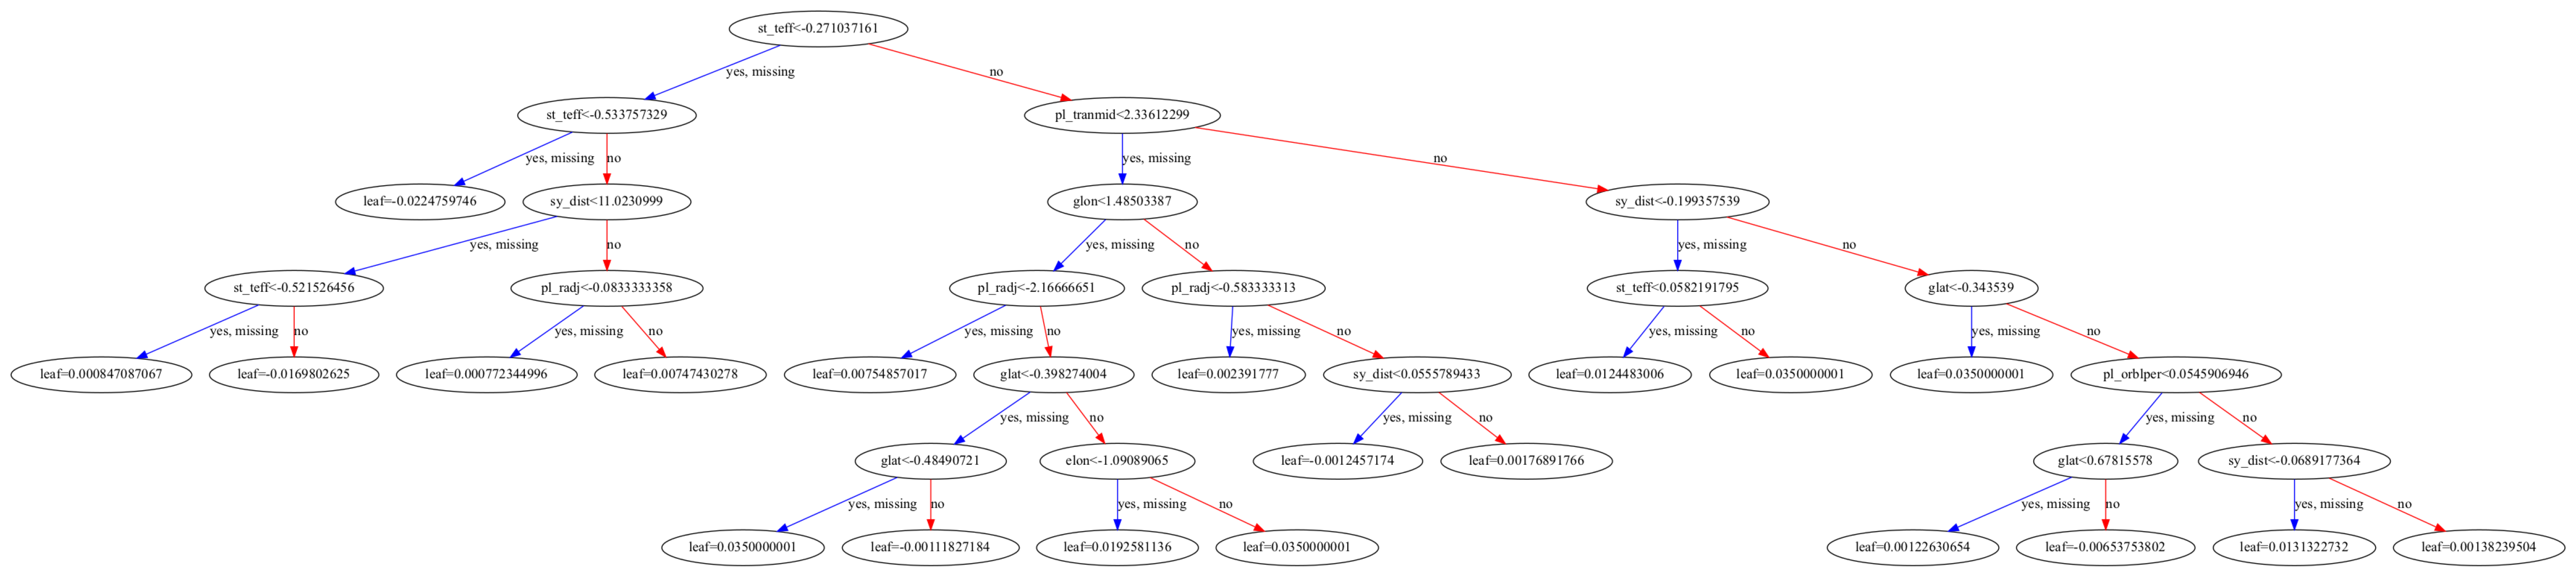

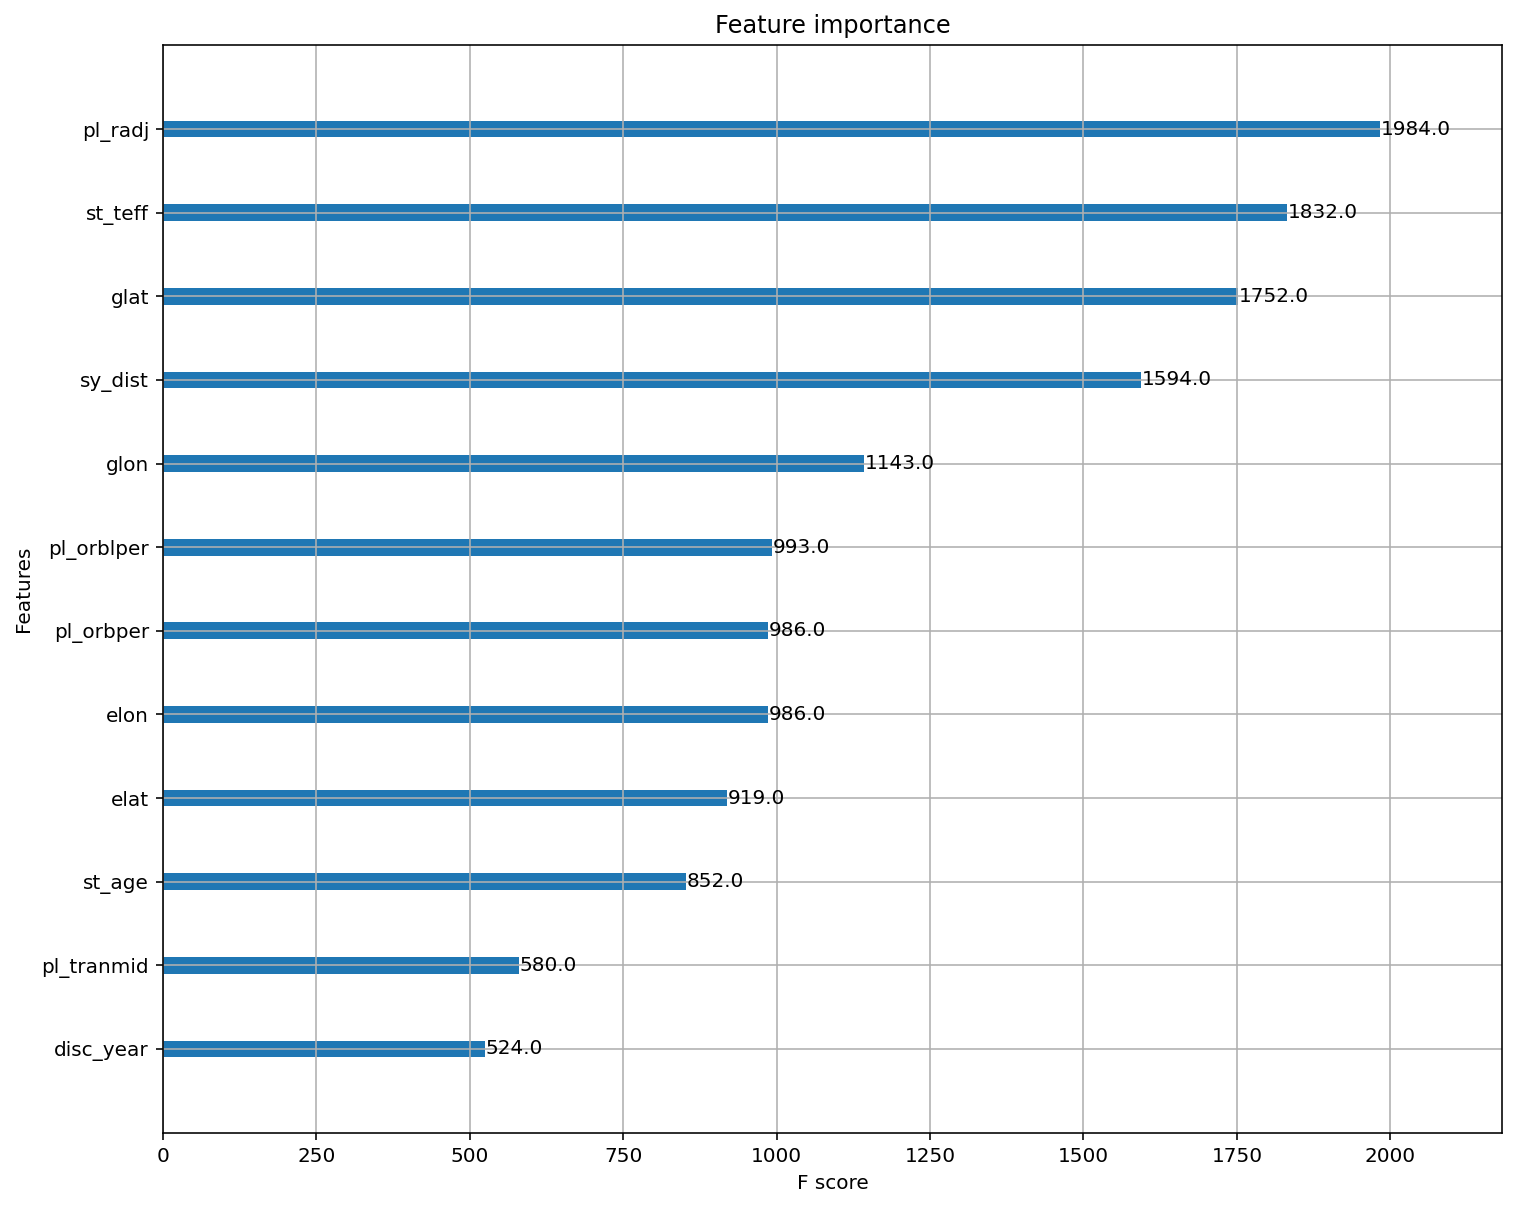

In [64]:
if override:
    pass
else:
    fig, ax = plt.subplots(figsize=(45,45))
    model = clf.named_steps.model.named_steps.crossValidation.best_estimator_
    model.get_booster().feature_names = [i for i in features if not any(c in i for c in ['pl_name', 'pl_massj'])]
    plot_tree(model.get_booster(), ax=ax)

    fig, ax = plt.subplots(figsize=(12,10))
    plot_importance(model.get_booster(), ax=ax)

# Prediction vs. Forecaster

In [65]:
df = compare_predict_vs_test(X, X_test, y_test, y_pred)

Predicting the Mass:

+--------------+---------+--------------+--------------+----------------------------+----------------------------+---------------------------+
| Planet       |    Test |   Prediction |   Forecaster |   Residual Test-Prediction |   Residual Test-Forecaster | Prediction < Forecaster   |
|--------------+---------+--------------+--------------+----------------------------+----------------------------+---------------------------|
| AU Mic c     | 0.04279 |      0.65847 |      0.03317 |                    0.61568 |                    0.00962 | False                     |
| HATS-2 b     | 1.53000 |      1.45167 |      2.68928 |                    0.07833 |                    1.15928 | True                      |
| K2-237 b     | 1.23600 |      1.31191 |     14.66466 |                    0.07591 |                   13.42866 | True                      |
| Lupus-TR-3 b | 0.81000 |      0.77310 |     11.63936 |                    0.03690 |                   10.82936 | True 

In [66]:
with suppress_print():
    df = compare_predict_vs_test(X, X_test, y_test, y_pred)
    count = 0
    count_resid = 0
    while df['Prediction < Forecaster'].sum() > 7:
        df = compare_predict_vs_test(X, X_test, y_test, y_pred)
        count += 1
        count_resid += df['Prediction < Forecaster'].sum()
print(f'It took {count} runs for Forecaster to beat the Regressor.')
print(f'Prediction beat Forecaster {count_resid}/{count*15} times.')

TypeError: 'NoneType' object is not subscriptable

In [ ]:

import eli5
perm = permutations()
if override:
    weights = eli5.show_weights(perm, feature_names = X_test.select_dtypes('number').columns.tolist())
else:
    # weights = eli5.show_weights(perm, feature_names = X_test.drop('pl_name', axis=1).columns.tolist())
    pass
#weights

